In [3]:
import glob
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
import webdataset as wds
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from torch import nn, optim
from torch.utils.data import DataLoader, IterableDataset
from torchvision import transforms
from torchvision.models import EfficientNet_B0_Weights, efficientnet_b0
from tqdm import tqdm

In [ ]:
# Change the following paths to run the script
PATH_TO_CSV = "./1k-coins-dataset-no-pr.csv"
PATH_TO_DATA = "1k-coins-dataset-no-pr"

df = pd.read_csv(PATH_TO_CSV)
df_ms = df[df["grade"].str.startswith("MS")]

df_train_ms = df_ms[df_ms["split"] == "train"]
df_test_ms = df_ms[df_ms["split"] == "test"]

id_to_grade = dict(zip(df_ms["id"], df_ms["grade"]))
unique_grades = sorted(set(id_to_grade.values()))
grade_to_idx = {g: i for i, g in enumerate(unique_grades)}
idx_to_grade = {i: g for g, i in grade_to_idx.items()}
id_to_idx = {cid: grade_to_idx[grade] for cid, grade in id_to_grade.items()}

train_len = len(df_train_ms)
test_len = len(df_test_ms)

TRAIN_SHARDS = os.path.join(PATH_TO_DATA, "train-dataset-{0000..0029}.tar")
TEST_SHARDS = os.path.join(PATH_TO_DATA, "test-dataset-{0000..0003}.tar")


def make_pipeline(shard_pattern: str, length: int) -> wds.WebDataset:
    base = (
        wds.WebDataset(shard_pattern, empty_check=False)
        .with_length(length)
        .decode("pil")
    )

    def process(sample):
        cid = sample["__key__"]
        if cid not in id_to_idx:
            return None
        return {
            "obv": sample["obverse.jpg"],
            "rev": sample["reverse.jpg"],
            "label": id_to_idx[cid],
        }

    return base.map(process)


class CoinDataset(IterableDataset):
    def __init__(self, pipeline, dataset_len, transform=None):
        self.pipeline = pipeline
        self._len = dataset_len
        self.transform = transform or (lambda x: x)

    def __iter__(self):
        for sample in self.pipeline:
            obv = self.transform(sample["obv"])
            rev = self.transform(sample["rev"])
            img6 = torch.cat([obv, rev], dim=0)
            yield img6, sample["label"]

    def __len__(self):
        return self._len



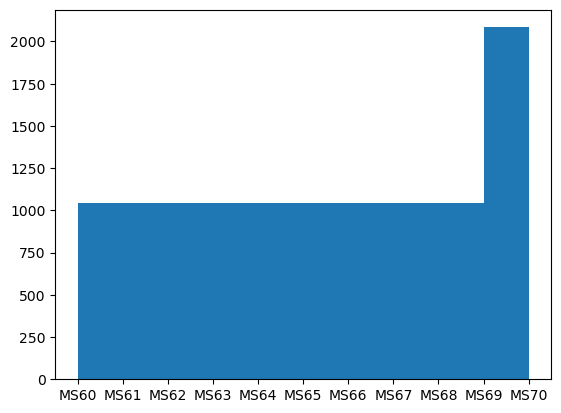

In [66]:
plt.hist(df_train_ms['grade'])
plt.show()

In [67]:
def plot_each_class(labels, pipeline):
    fig, axs = plt.subplots(ncols=len(labels), nrows=2, figsize=(len(labels)*3, 3))
    i=0
    while not(labels is None):
        sample = next(iter(pipeline))
        grade = idx_to_grade[sample['label']]
        # print(grade)
        print(labels)
        if  grade in labels:
            labels.remove(grade)
            axs[i, 0].imshow(sample['obv'])
            axs[i, 1].imshow(sample['rev'])
            
            axs[i, 0].set_title(grade)

            axs[i, 0].set_axis_off()
            axs[i, 1].set_axis_off()
            i += 1
    

In [68]:
img_size = 128

train_transform = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

train_pipeline = make_pipeline(TRAIN_SHARDS, length=train_len)
test_pipeline = make_pipeline(TEST_SHARDS, length=test_len)

train_dataset = CoinDataset(
    train_pipeline, dataset_len=train_len, transform=train_transform
)
test_dataset = CoinDataset(
    test_pipeline, dataset_len=test_len, transform=test_transform
)



/home/maly/miniconda3/envs/coins/lib/python3.10/site-packages/webdataset/compat.py:389: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn(
/home/maly/miniconda3/envs/coins/lib/python3.10/site-packages/webdataset/pipeline.py:176: UserWarning: .with_length() only sets the value of __len__ for compatibility with some training environments. It does not change the number of samples in an epoch.
  warnings.warn(


In [69]:
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=8,)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=8)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

/home/maly/miniconda3/envs/coins/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115564/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
old_conv = model.features[0][0]
new_conv = nn.Conv2d(
    in_channels=6,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=(old_conv.bias is not None),
)

with torch.no_grad():
    new_conv.weight[:, :3] = old_conv.weight
    new_conv.weight[:, 3:] = old_conv.weight

model.features[0][0] = new_conv
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, len(unique_grades))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

ckpt_dir = "checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

ckpts = sorted(glob.glob(os.path.join(ckpt_dir, "epoch_*.pt")))
if ckpts:
    ckpt = torch.load(ckpts[-1], map_location=device)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    start_epoch = ckpt["epoch"] + 1
else:
    start_epoch = 1

In [9]:

num_epochs = 5
for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for imgs6, labels in tqdm(train_loader, leave=False):
        imgs6, labels = imgs6.to(device), labels.to(device)
        outputs = model(imgs6)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    epoch_loss = running_loss / train_len
    ckpt_path = os.path.join(ckpt_dir, f"epoch_{epoch}.pt")
    torch.save(
        {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "loss": epoch_loss,
        },
        ckpt_path,
    )


KeyboardInterrupt: 

Accuracy: 0.3161, F1 Score: 0.2912


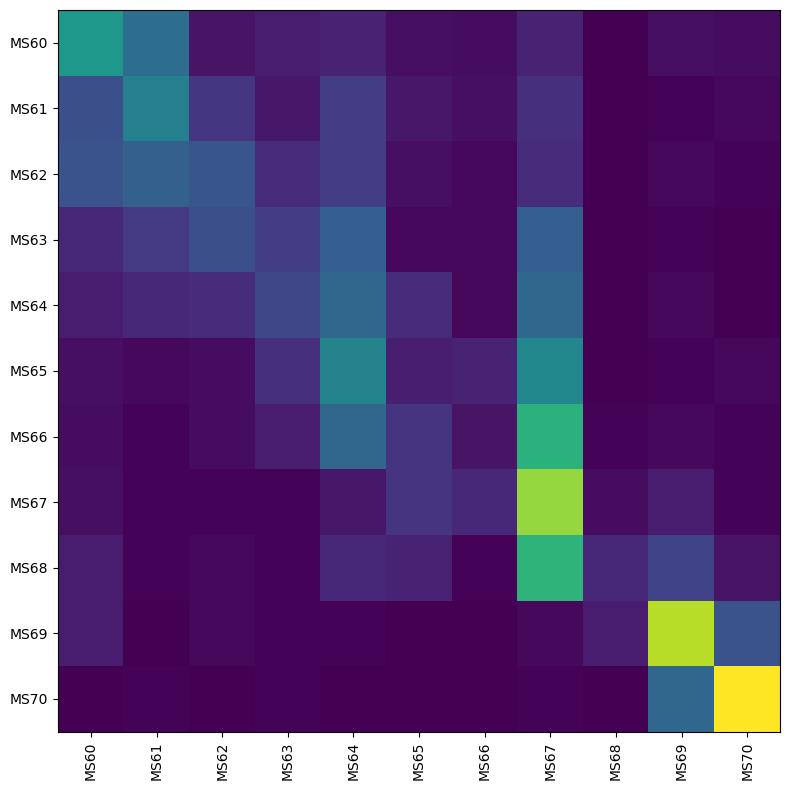

In [ ]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs6, labels in tqdm(test_loader):
        imgs6, labels = imgs6.to(device), labels.to(device)
        outputs = model(imgs6)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")
print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

cm = confusion_matrix(all_labels, all_preds)
os.makedirs("metrics", exist_ok=True)
torch.save(cm, "metrics/confusion_matrix.pt")
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest")
plt.xticks(range(len(unique_grades)), unique_grades, rotation=90)
plt.yticks(range(len(unique_grades)), unique_grades)
plt.tight_layout()
plt.savefig("metrics/confusion_matrix.png", dpi=200)
